In [20]:
%load_ext autoreload
%autoreload 2
from paths import *
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.utils
import torch.distributions
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from src.SERS_dataset import IterDataset
from src.generate_data2 import pseudoVoigtSimulatorTorch
from src.models.vanilla_VAE import VariationalAutoencoder
from torch import Tensor
from src.plotting.VAE_plotting import *
from src.trainers.VAE_trainer import VAE_trainer

# Matplot lib style
plt.style.use('seaborn-whitegrid')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda = torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\andre\AppData\Local\Temp\ipykernel_28496\1695632326.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


# Generator 1
Varying $\alpha$

In [21]:
#==============================================================================
# Define the hyperparameters
#==============================================================================
latent_dims = 2
epochs = 100
num_batches_per_epoch = 10
learning_rate = 1e-3
optimizer = "adam"
beta = 1
batch_size = 100

#==============================================================================
# Load the data
#==============================================================================
ps = pseudoVoigtSimulatorTorch(500)
generator = ps.predefined_generator(1)
dset_train = IterDataset(generator)
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=batch_size, pin_memory=cuda)

#==============================================================================
# Define the model
#==============================================================================
autoencoder = VariationalAutoencoder(next(iter(train_loader))[0][1].shape, latent_dims, batch_size, "alpha").to(device) 

#==============================================================================
# Train the model
#==============================================================================

autoencoder, train_loss = VAE_trainer(autoencoder, train_loader, 
                                        optimizer=optimizer, epochs=epochs, 
                                        num_iterations_per_epoch=num_batches_per_epoch,
                                        lr=learning_rate,beta=beta, label="alpha")


KeyboardInterrupt: 

In [12]:
train_loss["loss"][-1]

370.92810613458806

In [13]:
x , y = next(iter(train_loader))
x = x.to(device)
z, mu, logvar = autoencoder.encode(x)
x_hat = autoencoder.decode(z)
x_hat_mu = autoencoder.decode(mu)
sigma = torch.exp(0.5*logvar)
z = z.to('cpu').detach().numpy()
mu = mu.to('cpu').detach().numpy()
sigma = sigma.to('cpu').detach().numpy()

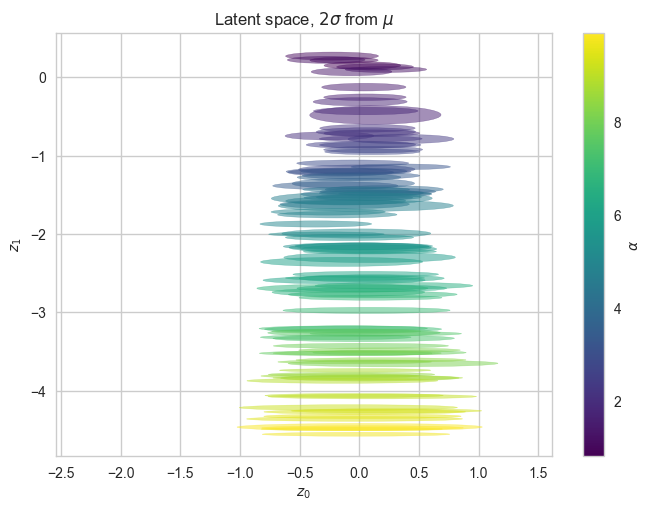

In [14]:
plt_latent_space_ellipses(z, mu, sigma, y[:,3].to('cpu').detach().numpy(), '$\\alpha$')

(100,) (100,)


Text(0, 0.5, 'sigma')

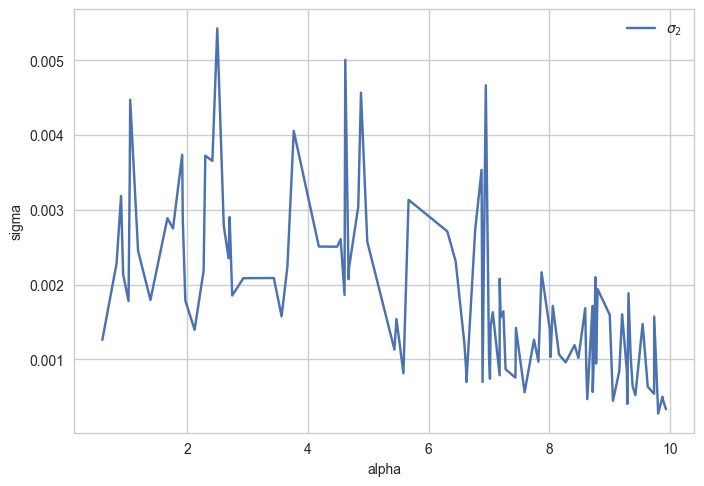

In [17]:
x , y = next(iter(train_loader))
x = x.to(device)
z, mu, logvar = autoencoder.encode(x)
sigma = torch.exp(logvar)
z = z.to('cpu').detach().numpy()
mu = mu.to('cpu').detach().numpy()
sigma = sigma.to('cpu').detach().numpy()

alpha = y[:,3].to('cpu').detach().numpy()
alpha = alpha.flatten()
sort = np.argsort(alpha)
z = z[sort]
mu = mu[sort]
sigma1 = sigma[:,0].flatten()
sigma2 = sigma[:,1].flatten()
print(sigma1.shape, sigma2.shape)
sigma1 = sigma1[sort]
sigma2 = sigma2[sort]

y = y[sort]
alpha = alpha[sort]

# sigma[:,0]

# plt.plot(alpha, sigma1, '-', label='$\\sigma_1$')
plt.plot(alpha, sigma2, '-', label = '$\\sigma_2$')
plt.legend()


# axes 
plt.xlabel('alpha')
plt.ylabel('sigma')


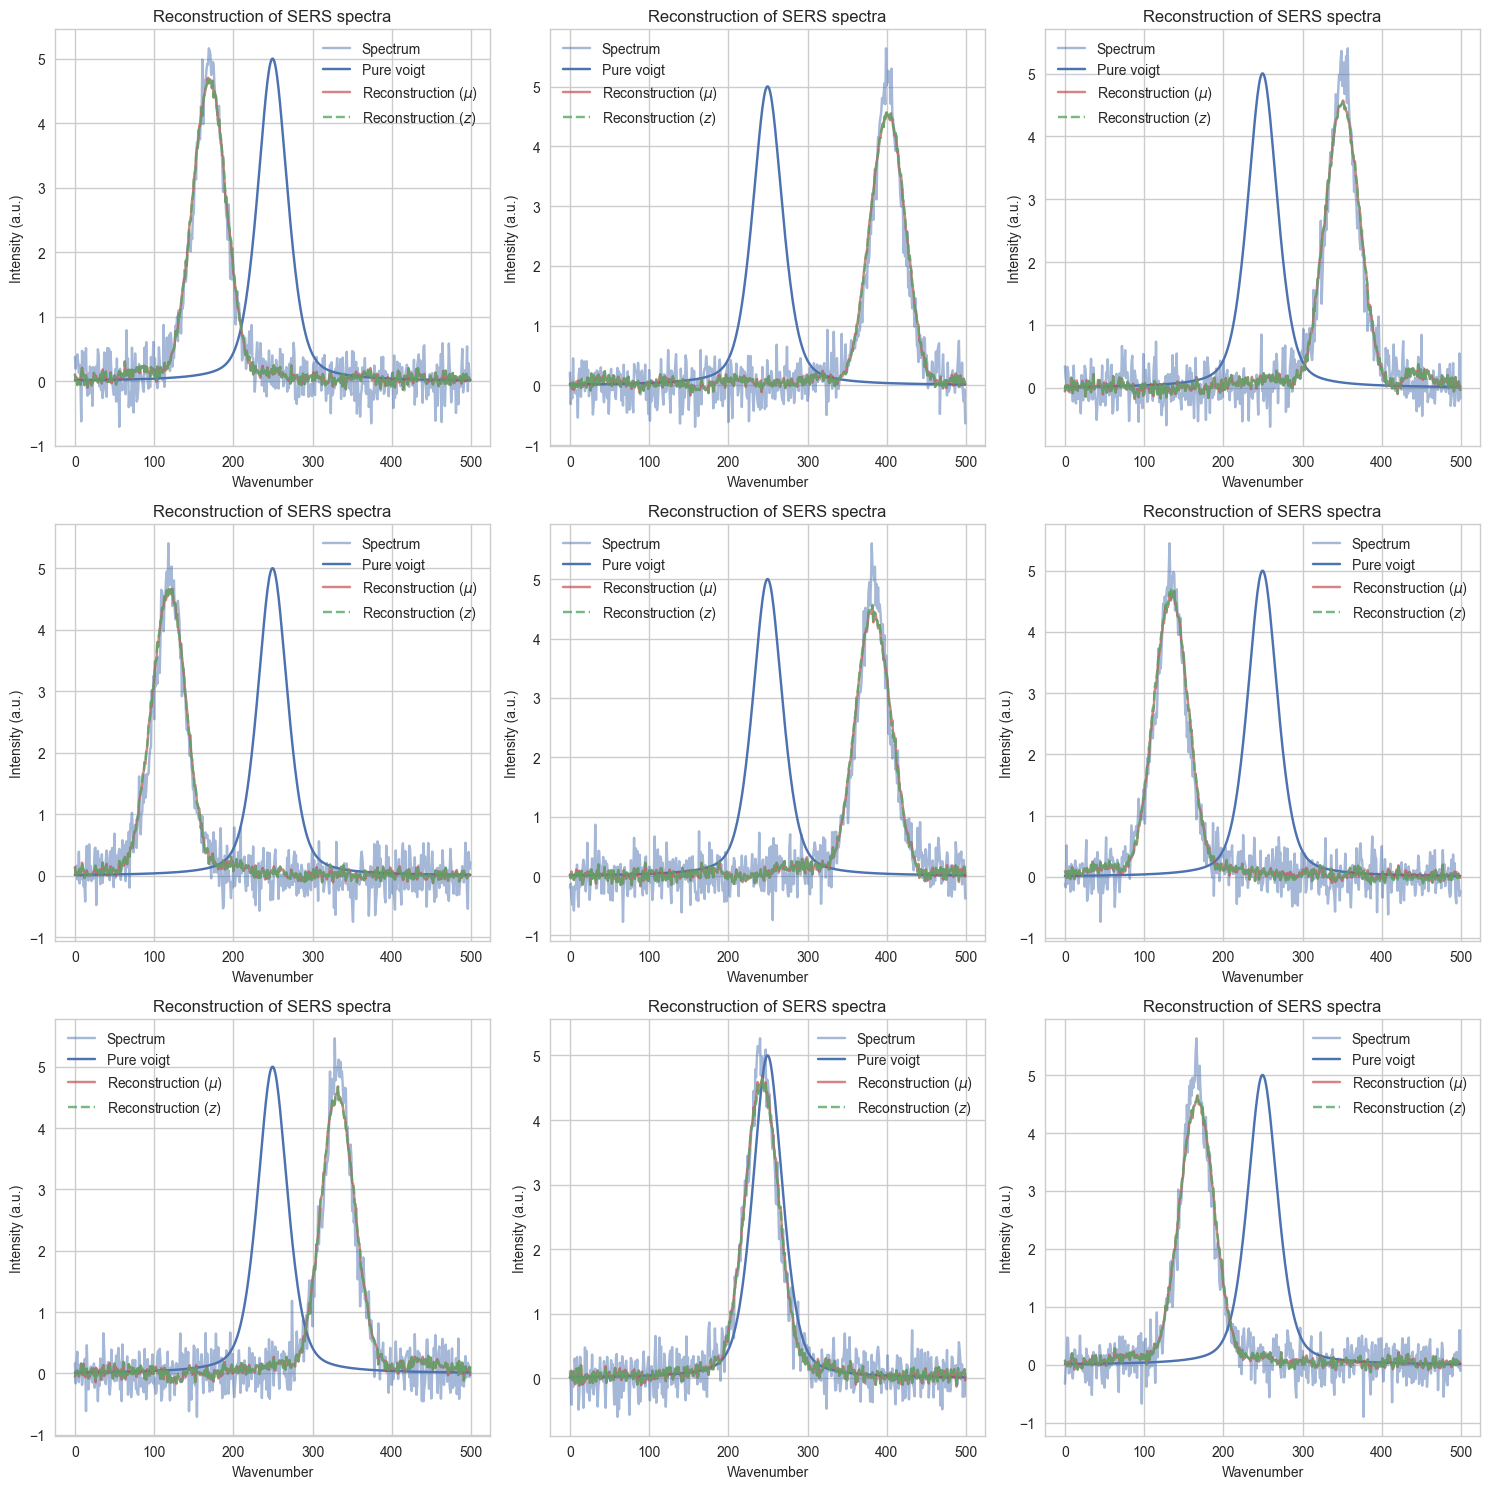

In [176]:
ps = pseudoVoigtSimulatorTorch(500)

def full_spec(x):
    return ps.generate_full_spectrum(peaks = torch.tensor([250]), gamma = torch.tensor([20]), eta = torch.tensor([0.5]), alpha = x, sigma = 0, height_normalize=True, wavenumber_normalize=True)

x_ = x.to('cpu').detach().numpy()
x_hat_ = x_hat.to('cpu').detach().numpy()
x_hat_mu_ = x_hat_mu.to('cpu').detach().numpy()

plt_reconstructions(x_, x_hat_, x_hat_mu_, y[:,3], 3, full_spec)

# Varying $c$

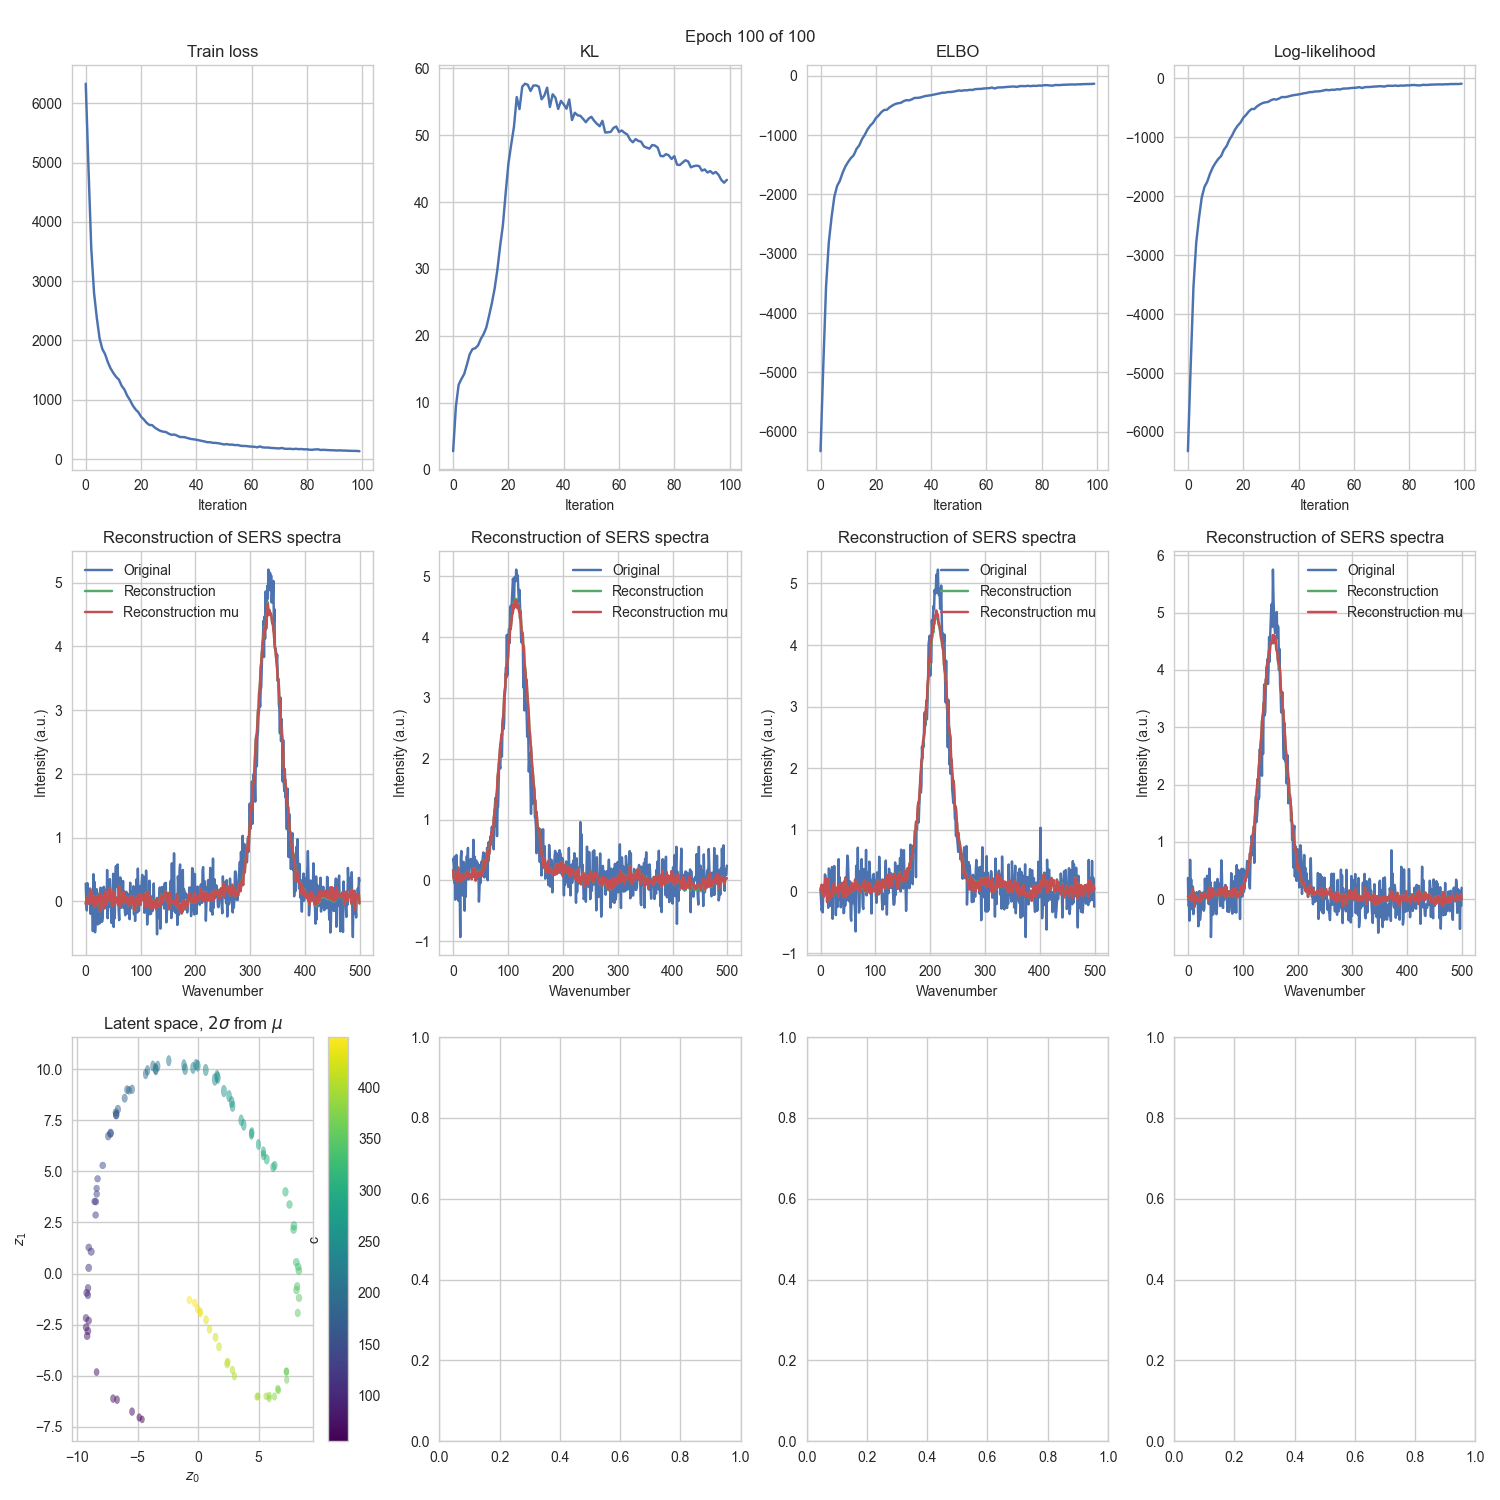

In [172]:
latent_dims = 2
epochs = 100
num_batches_per_epoch = 10
learning_rate = 1e-3
optimizer = "adam"
beta = 1


batch_size = 100
ps = pseudoVoigtSimulatorTorch(500)
generator = ps.generator(1, peaks = (50,450), gamma = torch.tensor([20]), eta = torch.tensor([0.5]), alpha = torch.tensor([5]), sigma = 0.5)

dset_train = IterDataset(generator)

# Load the SERS dataset
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=batch_size, pin_memory=cuda)

autoencoder = VariationalAutoencoder(next(iter(train_loader))[0][1].shape, latent_dims, batch_size, "c").to(device) 

#==============================================================================
# Train the model
#==============================================================================

autoencoder, train_loss = train(autoencoder, train_loader, 
                                        optimizer=optimizer, epochs=epochs, 
                                        num_iterations_per_epoch=num_batches_per_epoch,
                                        lr=learning_rate,beta=beta, label="c")


In [173]:
x , y = next(iter(train_loader))
x = x.to(device)
z, mu, logvar = autoencoder.encode(x)
x_hat = autoencoder.decode(z)
x_hat_mu = autoencoder.decode(mu)
sigma = torch.exp(0.5*logvar)
z = z.to('cpu').detach().numpy()
mu = mu.to('cpu').detach().numpy()
sigma = sigma.to('cpu').detach().numpy()

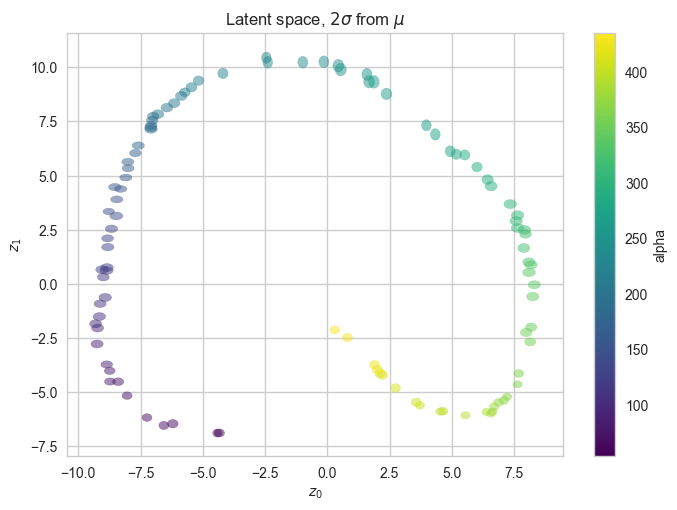

In [174]:
plt_latent_space_ellipses(z, mu, sigma, y[:,0].to('cpu').detach().numpy(), 'alpha')

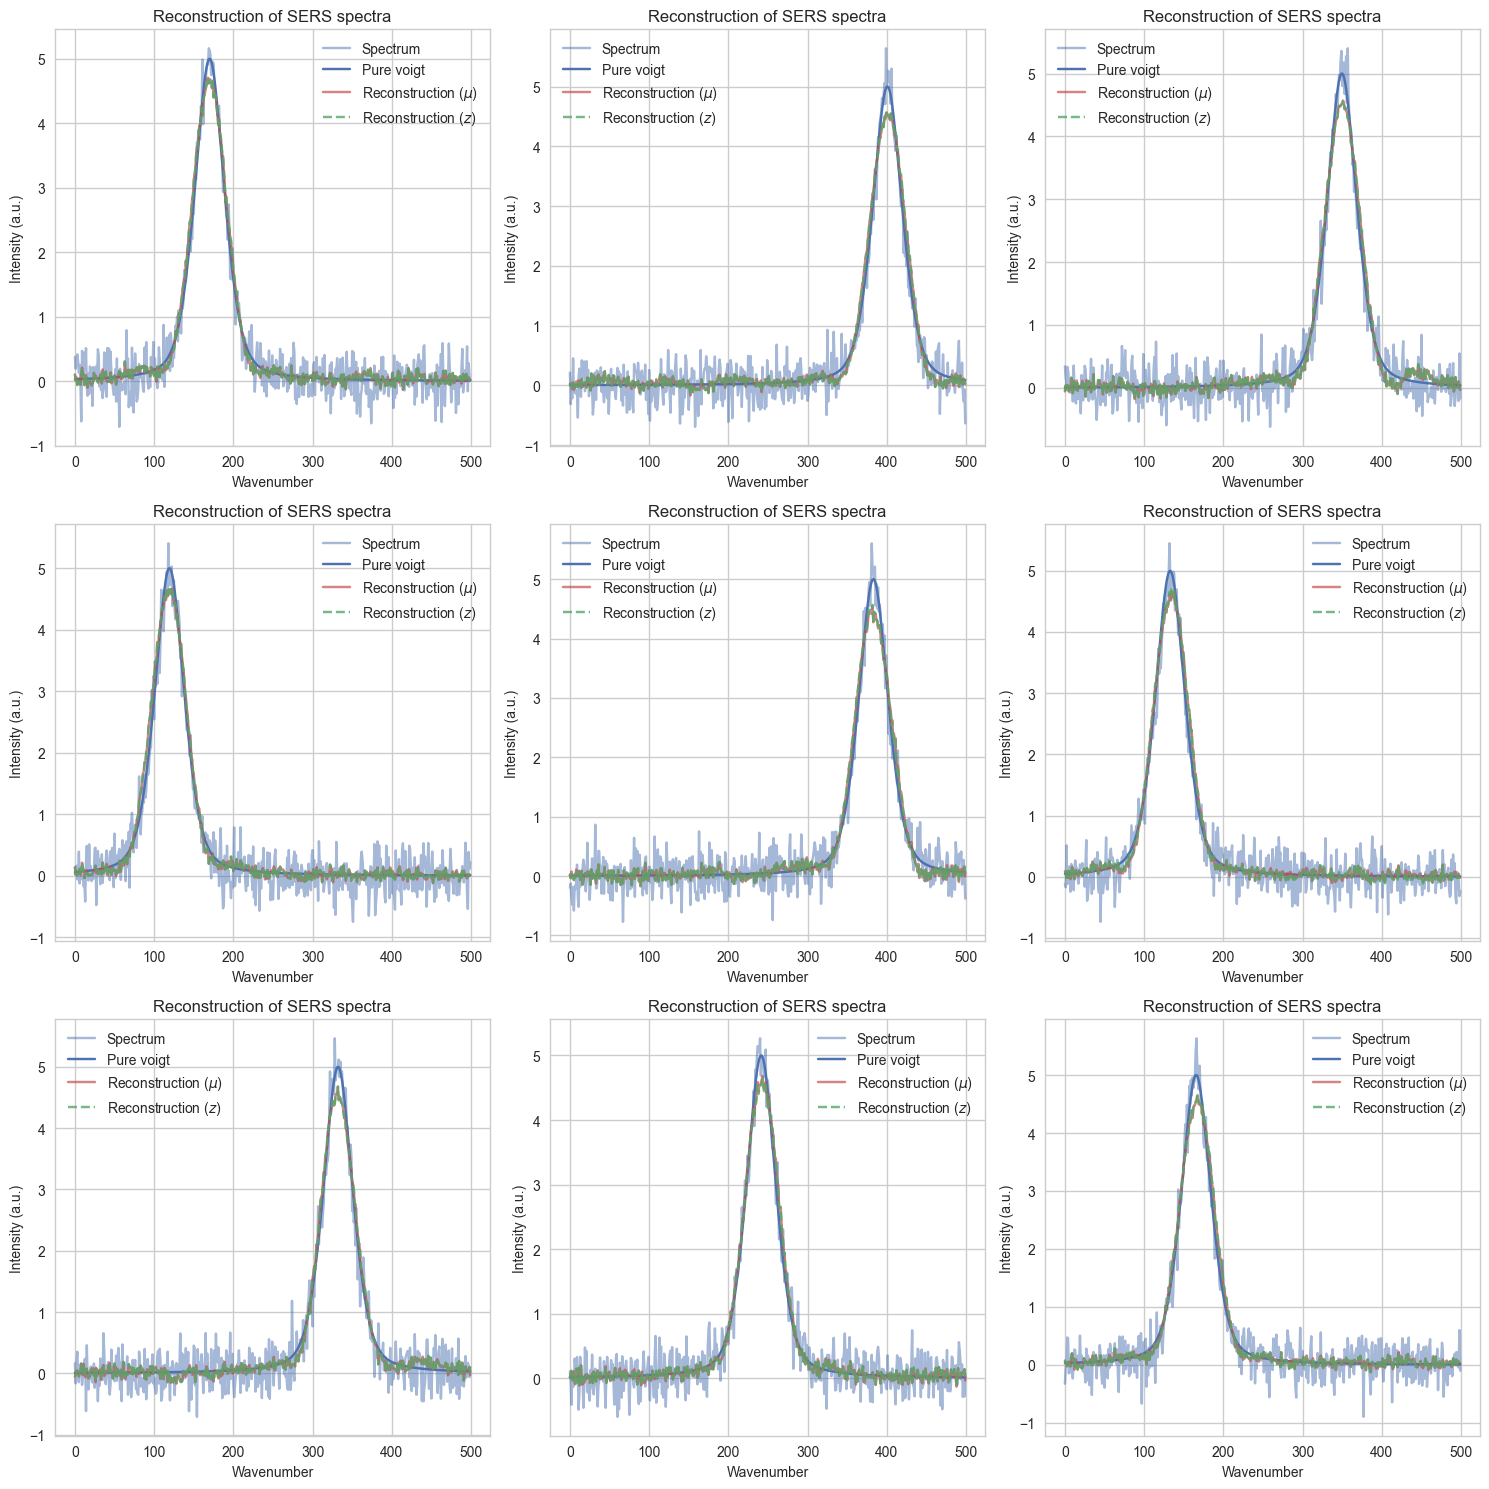

In [175]:
ps = pseudoVoigtSimulatorTorch(500)

def full_spec(x):
    return ps.generate_full_spectrum(peaks = x, gamma = torch.tensor([20]), eta = torch.tensor([0.5]), alpha = torch.tensor([5]), sigma = 0, height_normalize=True, wavenumber_normalize=True)

x_ = x.to('cpu').detach().numpy()
x_hat_ = x_hat.to('cpu').detach().numpy()
x_hat_mu_ = x_hat_mu.to('cpu').detach().numpy()

plt_reconstructions(x_, x_hat_, x_hat_mu_, y[:,0], 3, full_spec)

# Both

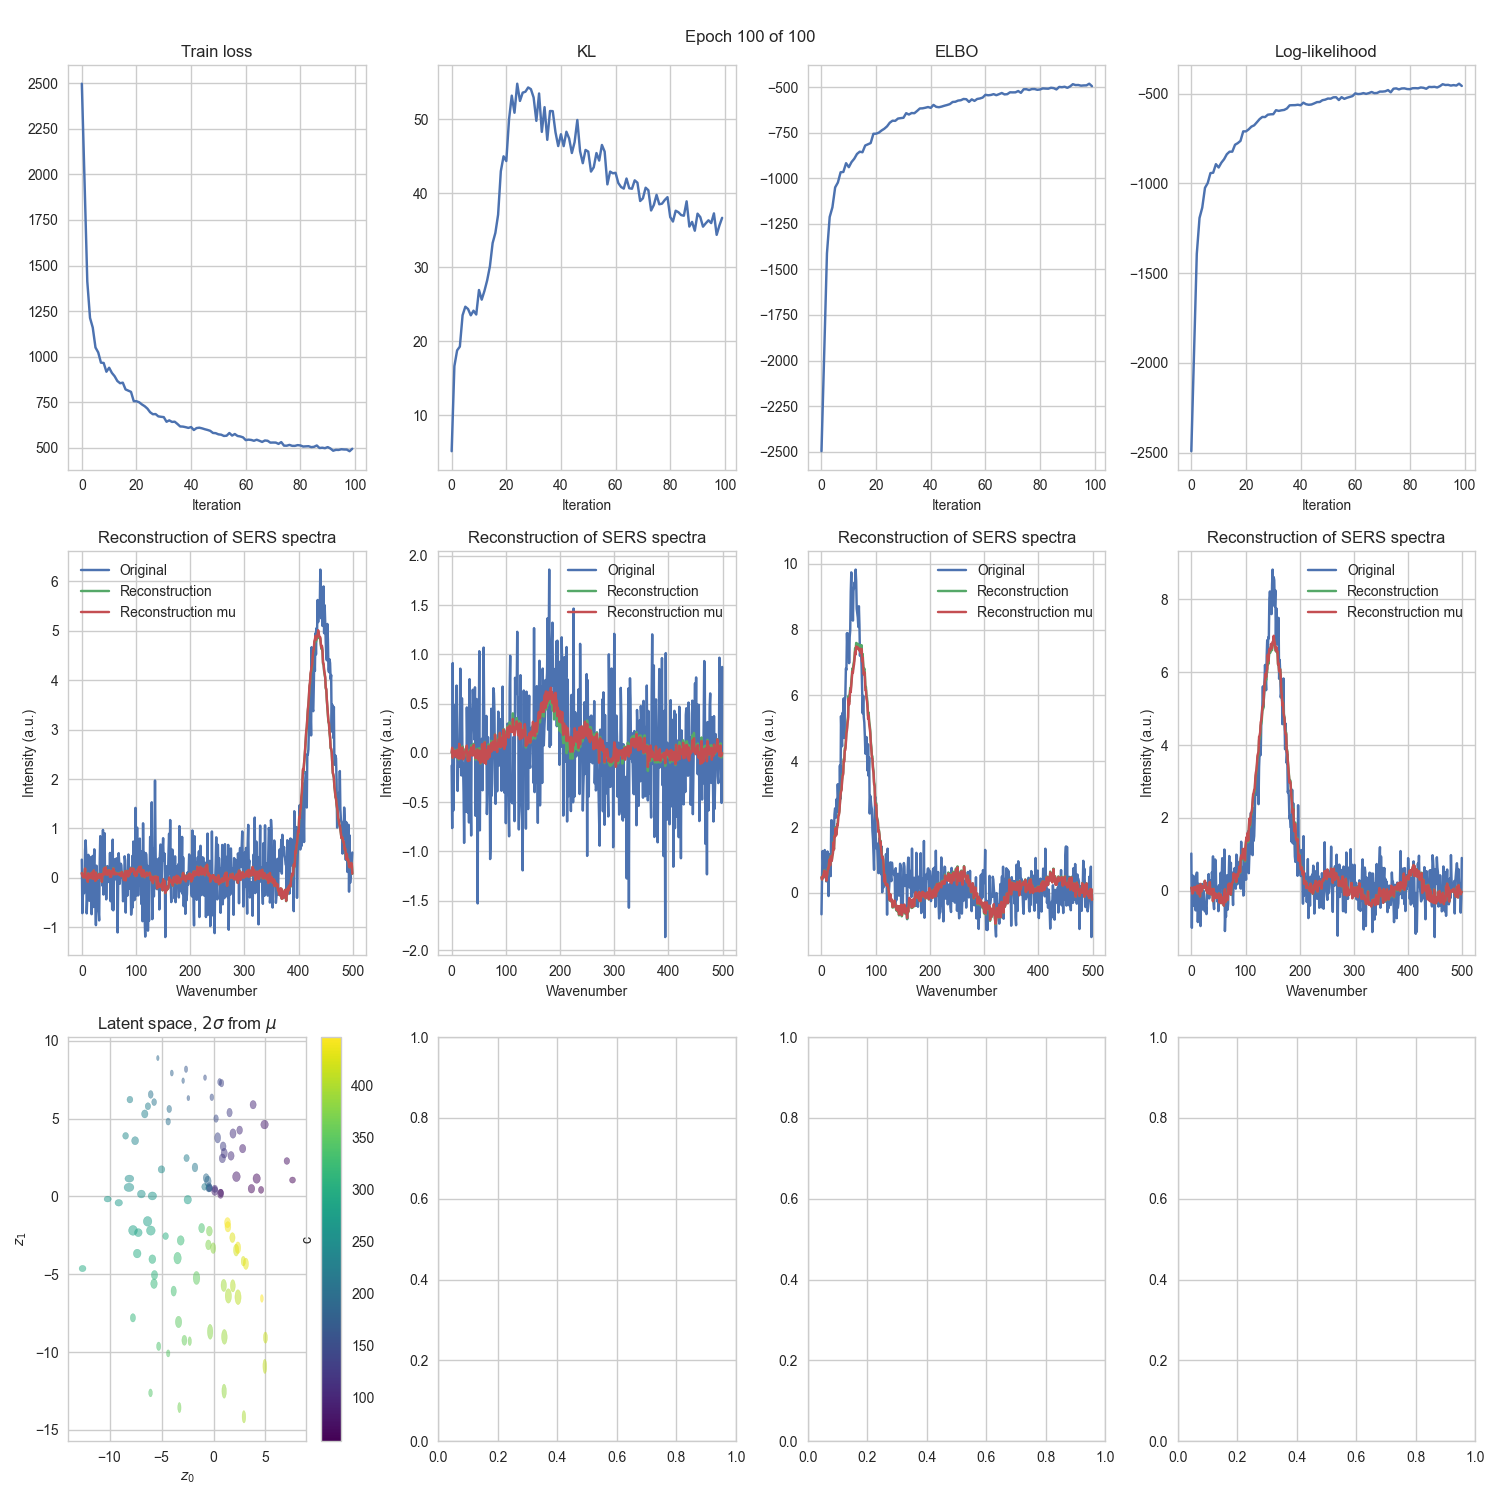

In [23]:
latent_dims = 2
epochs = 100
num_batches_per_epoch = 10
learning_rate = 1e-3
optimizer = "adam"
beta = 1


batch_size = 100
ps = pseudoVoigtSimulatorTorch(500)
generator = ps.generator(1, peaks = (50,450), gamma = torch.tensor([20]), eta = torch.tensor([0.5]), alpha = (0.5,10), sigma = 0.5)

dset_train = IterDataset(generator)

# Load the SERS dataset
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=batch_size, pin_memory=cuda)

autoencoder = VariationalAutoencoder(next(iter(train_loader))[0][1].shape, latent_dims, batch_size, ["c", "alpha"]).to(device) 

#==============================================================================
# Train the model
#==============================================================================

autoencoder, train_loss = train(autoencoder, train_loader, 
                                        optimizer=optimizer, epochs=epochs, 
                                        num_iterations_per_epoch=num_batches_per_epoch,
                                        lr=learning_rate,beta=beta, label=["c", "alpha"])
